# Stock exchange prediction for fun

Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


Read and prepare OHLC data, 5 minute bars

Create predictors from input data


In [232]:
predictors=df.reset_index().drop(['datetime'],axis=1)
target=predictors.shift(-1)[['high','low']][:-1]
predictors=predictors[:-1]


In [233]:
predictors.tail()

,open,high,low,close,vol
4886,1281.54,1282.89,1281.47,1282.68,11307910.0
4887,1282.69,1283.14,1281.92,1282.12,11017460.0
4888,1282.06,1285.36,1282.06,1284.80,12692191.0
4889,1284.80,1284.80,1282.52,1283.14,12809211.0
4890,1283.20,1283.46,1282.92,1283.21,3378532.0


In [234]:
target.tail()

,high,low
4886,1283.14,1281.92
4887,1285.36,1282.06
4888,1284.80,1282.52
4889,1283.46,1282.92
4890,1285.80,1285.80


Predict with neural network
Prepare train/test input

In [235]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

input_size = predictors.shape[1]
window_size=24

# Normalize and Split to train and test
scaler=StandardScaler()
predictors_norm=scaler.fit_transform(predictors)
target_norm=scaler.fit_transform(target)
X_train, X_test, y_train, y_test = train_test_split(predictors_norm, target_norm, test_size=0.3, shuffle=False)

Create and fit the model

In [236]:
from keras import optimizers

# Create the model
model=Sequential()
model.add(Dense(input_size, batch_size=window_size))
model.add(Dense(input_size*window_size, activation='relu'))
model.add(Dense(input_size, activation='relu'))
# High/Low prediction output
model.add(Dense(2))

optimizer=optimizers.Adam()
#optimizer=optimizers.SGD()
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# Fit
#early_stopping = EarlyStopping(patience=5)
#history = model.fit(X_train, y_train, validation_split=0.3, epochs=20, callbacks=[early_stopping], shuffle=False, verbose=False)
epochs=20
history = model.fit(X_train, y_train, validation_split=0.3, epochs=epochs, shuffle=False, verbose=False)

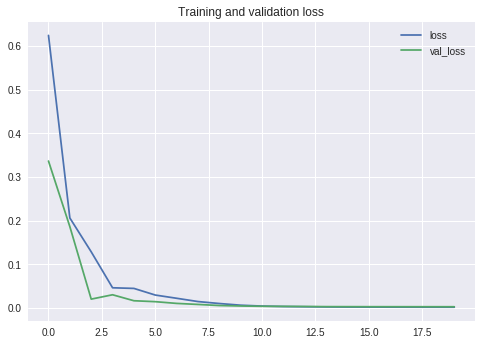

In [237]:
#model.fit(X_train, y_train, validation_split=0.3, epochs=200, shuffle=True, verbose=True)
#plt.plot(history.history['mean_squared_error'])

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# Predict

Evaluate

In [238]:
scores=model.evaluate(X_test, y_test, verbose=False)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

mean_squared_error: 0.28%


Predicted values EDA

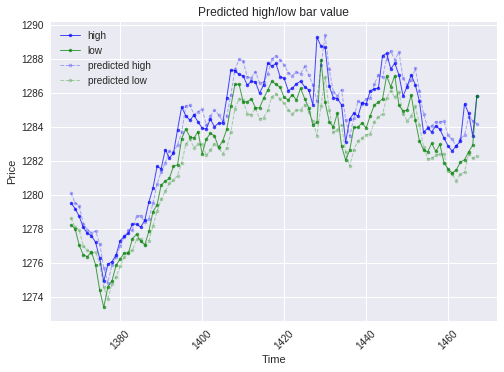

In [239]:
y=model.predict(X_test)
#from mpl_finance import candlestick_ohlc
plt.style.use('seaborn')
#fig,ax = plt.subplots()
#quotes=df.reset_index()
#quotes.columns=['date','open','high','low','close','vol']
#quotes=quotes[['date','open','high','low','close']]
#quotes['date'] = quotes['date'].apply(mdates.date2num)
#candlestick_ohlc(ax,quotes.values, width=.001, colorup='blue', colordown='green')
#candlestick_ohlc(ax,quotes.values, width=.03, alpha=0.5, colorup='black', colordown='red')

last_points=100
original=pd.DataFrame(scaler.inverse_transform(y_test), columns=['high', 'low']).reset_index()[-last_points:]
plt.plot(original['high'], marker='.', linestyle='solid', color='b', alpha=0.7, linewidth=1)
plt.plot(original['low'], marker='.', linestyle='solid', color='green', alpha=0.7, linewidth=1)

actual=pd.DataFrame(scaler.inverse_transform(y), columns=['high','low']).reset_index()[-last_points:]
plt.plot(actual['high'], marker='.', linestyle='dashed', color='b', alpha=0.3, linewidth=1)
plt.plot(actual['low'], marker='.', linestyle='dashed', color='green', alpha=0.3, linewidth=1)

#plt.ylim(min(original['high']),max(original['high']))
#plt.xlim(1380, 1400)

plt.title('Predicted high/low bar value')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.legend(["high", "low", "predicted high", "predicted low"])
plt.show()

.. To be continue ...